# Libraries & Functions

In [29]:
import sys
import importlib.metadata as metadata  # For Python 3.8+

import sklearn
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import nltk
import gensim
import yfinance
import torch
import transformers
import tqdm
import xgboost
import shap
import umap

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("nltk:", nltk.__version__)
print("gensim:", gensim.__version__)
print("yfinance:", yfinance.__version__)
print("torch (PyTorch):", torch.__version__)
print("transformers:", transformers.__version__)
print("tqdm:", tqdm.__version__)
print("xgboost:", xgboost.__version__)
print("shap:", shap.__version__)
print("umap-learn:", umap.__version__)

# Handle ta version (fallback if __version__ doesn't exist)
try:
    print("ta (technical analysis):", metadata.version("ta"))
except:
    print("ta (technical analysis): version not found")

Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
pandas: 1.5.3
numpy: 1.23.5
matplotlib: 3.7.1
seaborn: 0.12.2
scikit-learn: 1.2.1
nltk: 3.8.1
gensim: 4.3.3
yfinance: 0.2.55
torch (PyTorch): 2.1.0+cpu
transformers: 4.26.0
tqdm: 4.65.0
xgboost: 3.0.0
shap: 0.47.1
umap-learn: 0.5.7
ta (technical analysis): 0.11.0


In [26]:
# Standard Libraries
import re
import string
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Machine Learning & Model Evaluation
from sklearn.model_selection import (
    train_test_split
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve, 
    roc_auc_score, 
    RocCurveDisplay
)
from sklearn.preprocessing import *

from sklearn.preprocessing import StandardScaler
from umap import UMAP

# NLP Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.tokenize import word_tokenize
import contractions
from gensim.models import Word2Vec

# Financial Data & Technical Analysis
import yfinance as yf
import ta  # Technical Analysis library

# Transformers & Deep Learning
import torch
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification
)
from tqdm import tqdm

# XGBoost
import xgboost as xgb

# SHAP for Explainability
import shap

from functools import lru_cache

In [2]:

def add_time_features(df):
    """
    Adds time-based features to a DataFrame with a DatetimeIndex.

    Parameters:
    df (pd.DataFrame): DataFrame with DatetimeIndex.

    Returns:
    pd.DataFrame: DataFrame with added time-based features.
    """
    df = df.copy()  # To avoid modifying the original DataFrame
    
    df['date'] = pd.to_datetime(df['date'])

    # Extract time features
    df['Day'] = df['date'].dt.day
    df['Weekday'] = df['date'].dt.weekday  # Monday=0, Sunday=6
    df['Week'] = df['date'].dt.isocalendar().week.astype(int)
    df['Month'] = df['date'].dt.month
    df['Year'] = df['date'].dt.year

    # Cyclic encoding for Month
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df



def create_target(df):
    """
    Creates a 'Target' column indicating whether the stock price moves up or down the next day.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'Close' column.
    
    Assumption:
    - 1 Minute Close price with actual close price won't be that much different
    - Neutral = Down

    Returns:
    pd.DataFrame: DataFrame with the added 'Target' column.
    """
    df = df.copy()
    df["Target"] = df["Open"].shift(-1) - df["Close"]
    df["Target"] = df["Target"].apply(lambda x: "Up" if x > 0 else "Down")

    # Remove the last row (since it has NaN in 'Target')
    df = df.iloc[:-1].reset_index(drop=True)

    return df



def encode_target(df, column):
    """
    Encodes a categorical target column using LabelEncoder.

    Parameters:
    df (pd.DataFrame): DataFrame containing the target column.
    column (str): Name of the column to encode.

    Returns:
    pd.DataFrame: DataFrame with the encoded target column.
    """
    df = df.copy()
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    return df, encoder  # Return encoder in case inverse transformation is needed



def show_encoded_classes(df, encoder, column):
    """
    Prints the encoded values and their corresponding class names for a given target column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the target column.
    encoder (LabelEncoder): The fitted LabelEncoder.
    column (str): The target column that was encoded.

    Returns:
    None
    """
    print("Encoded Values and Class Names:")
    for encoded_value, classname in enumerate(encoder.classes_):
        print(f"Encoded Value: {encoded_value}, Class Name: {classname}")



def feature_addition(df):
    # ===== 1. Lag Features (Past Prices) FIBONACCI SEQUENCE =====
    df['Close_1'] = df['Close'].shift(1)  # Previous day's close
    df['Close_2'] = df['Close'].shift(2)
    df['Close_3'] = df['Close'].shift(3)
    df['Close_5'] = df['Close'].shift(5)
    df['Close_8'] = df['Close'].shift(8)
    df['Close_13'] = df['Close'].shift(13)
    
    # ===== 1.1. Lag Features Percentage Change (New Ratio Columns) =====
    df['Close_1_pct_change'] = (df['Close'] - df['Close_1']) / df['Close_1']
    df['Close_2_pct_change'] = (df['Close'] - df['Close_2']) / df['Close_2']
    df['Close_3_pct_change'] = (df['Close'] - df['Close_3']) / df['Close_3']
    df['Close_5_pct_change'] = (df['Close'] - df['Close_5']) / df['Close_5']
    df['Close_8_pct_change'] = (df['Close'] - df['Close_8']) / df['Close_8']
    df['Close_13_pct_change'] = (df['Close'] - df['Close_13']) / df['Close_13']

    # ===== 2. Exponential Moving Averages (EMA) =====
    df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
    df['EMA_8'] = df['Close'].ewm(span=8, adjust=False).mean()
    df['EMA_13'] = df['Close'].ewm(span=13, adjust=False).mean()

    # ===== 3. Volatility Features =====
    # Rolling Standard Deviation
    df['Rolling_Std_10'] = df['Close'].rolling(10).std()  # 10-day volatility
    df['Rolling_Std_20'] = df['Close'].rolling(20).std()  # 20-day volatility

    # ===== 4. RSI (Momentum) =====
    df['RSI_5'] = ta.momentum.RSIIndicator(df['Close'], window=5).rsi()
    df['RSI_8'] = ta.momentum.RSIIndicator(df['Close'], window=8).rsi()
    df['RSI_13'] = ta.momentum.RSIIndicator(df['Close'], window=13).rsi()

    # ===== 5. MACD (Trend) =====
    macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()  # MACD line
    df['MACD_Signal'] = macd.macd_signal()  # Signal line
    df['MACD_Hist'] = macd.macd_diff()  # Histogram
    
    # ===== 6. Stochastic Oscillator =====
    df['stoch_k'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'], window=5, smooth_window=3)
    df['stoch_d'] = df['stoch_k'].rolling(3).mean()  # Signal line (%D)
    df['slow_stoch_k'] = df['stoch_k'].rolling(3).mean()  # Slower %K
    df['slow_stoch_d'] = df['slow_stoch_k'].rolling(3).mean()  # Slower %D
    
    # Label signals as categories
    df['signal'] = 'neutral'
    df.loc[df['stoch_k'] > 80, 'signal'] = 'overbought'
    df.loc[df['stoch_k'] < 20, 'signal'] = 'oversold'
    
    # One-hot encode the signal column
    signal_one_hot = pd.get_dummies(df['signal'], prefix='signal')
    df = pd.concat([df, signal_one_hot], axis=1)
    df.drop(columns=['signal'], inplace=True)

    # ===== 7. Volume Indicators =====
    df['Volume_MA_5'] = df['Volume'].rolling(5).mean()
    df['Volume_MA_10'] = df['Volume'].rolling(10).mean()
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()

    # ===== 8. Price Returns =====
    df['Daily_Return'] = df['Close'].pct_change()  # Daily % return
    df['Cumulative_Return_5'] = (df['Close'] / df['Close'].shift(5)) - 1  # 5-day return

    # ===== 9. Bollinger Bands =====
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['Upper_Band'] = df['MA_20'] + (2 * df['Rolling_Std_20'])
    df['Lower_Band'] = df['MA_20'] - (2 * df['Rolling_Std_20'])
    
    # ===== 10. ADX (Trend Strength) =====
    df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=14).adx()

    # Drop NaN rows (from rolling calculations)
    df.dropna(inplace=True)

    return df



def data_splitting(df, target_col, test_size):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    df (pd.DataFrame): The dataset
    target_col (str): The column name of the target variable
    test_size (float): The proportion of data to use for testing

    Returns:
    X_train, X_test, y_train, y_test (tuple): Train-test split datasets
    """
    df = df.sort_index()
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    return train_test_split(X, y, test_size=test_size, shuffle=False)



def train_evaluate_and_explain_xgboost(df_name, X_train, y_train, X_test, y_test, target_encoder):
    """
    Train an XGBoost classifier, evaluate its performance, and generate SHAP explanations.
    
    Parameters:
    df_name (str): Name of the dataset
    X_train (pd.DataFrame): Training features
    y_train (pd.Series): Training labels
    X_test (pd.DataFrame): Test features
    y_test (pd.Series): Test labels
    target_encoder: Fitted LabelEncoder for target values
    
    Returns:
    xgb.XGBClassifier: The trained model
    """
    
    # Train model with all randomness controlled
    xgboost_model = xgb.XGBClassifier(
        eval_metric='logloss',
        booster='gbtree',
        random_state=0
    )
    
    xgboost_model.fit(X_train, y_train)

    # Evaluation
    y_pred = xgboost_model.predict(X_test)
    test_accuracy = xgboost_model.score(X_test, y_test)
    y_probs = xgboost_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_probs)

    print(f"XGBoost Classifier Performance for {df_name}:")
    print("-" * 40)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"\nROC AUC Score: {auc_score:.4f}")
    print("=" * 40 + "\n")
    
    show_encoded_classes(df_name, target_encoder, "Target")
    print("=" * 40 + "\n")

    # ROC Curve Visualization
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {df_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # SHAP Explanations
    print("Generating SHAP Explanations...")
    
    # Create explainer and get SHAP values
    explainer = shap.Explainer(xgboost_model)
    shap_values = explainer(X_train)
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, show=False)
    plt.title(f"SHAP Feature Importance - {df_name}")
    plt.tight_layout()
    plt.show()

    # Bar plot
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values, show=False)
    plt.title(f"Feature Importance - {df_name}")
    plt.tight_layout()
    plt.show()

    # Force plot - fixed version
    shap.initjs()
    print("\nSHAP Force Plot for First Observation:")
    
    # Create proper Explanation object for force plot
    expected_value = explainer.expected_value
    if isinstance(expected_value, np.ndarray) and len(expected_value) > 1:
        expected_value = expected_value[1]  # For binary classification
        
    shap.force_plot(
        expected_value,
        shap_values.values[0],  # Use .values to get numpy array
        X_train.iloc[0],
        matplotlib=True,
        figsize=(12, 4),
        feature_names=X_train.columns.tolist()
    )



def process_financial_tweets(final_data, text_column, max_length_clf, max_length_vec, col_prefix, stock_symbol=None, timestamp_column=None):
    """
    Combined process for FinBERT sentiment analysis and vectorization of financial tweets
    1. Sentiment classification
    2. Tweet preprocessing
    3. Embedding/vectorization
    """
    # 1. Setup device and load models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load tokenizer and models
    tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    
    # Load classification model
    classification_model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')
    classification_model = classification_model.to(device)
    classification_model.eval()
    
    # Load embedding model (for vectorization)
    embedding_model = AutoModel.from_pretrained('yiyanghkust/finbert-tone')
    embedding_model = embedding_model.to(device)
    embedding_model.eval()
    
    # Track relevant stock symbols
    stock_symbols = set([stock_symbol]) if stock_symbol else set()
    
    # 2. Define classification function for batch processing
    def batch_classify(texts, batch_size=32):
        all_classes = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', truncation=True,
                             padding=True, max_length=max_length_clf).to(device)
            with torch.no_grad():
                outputs = classification_model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                pred_classes = torch.argmax(probs, dim=1).cpu().numpy() - 1  # Convert to -1/0/1
            all_classes.extend(pred_classes)
        return all_classes
    
    # 3. Define tweet-specific preprocessing
    def preprocess_tweet(text):
        text = str(text)
        
        # Extract and track cashtags instead of removing them
        cashtags = re.findall(r'\$([A-Za-z]+)', text)
        for symbol in cashtags:
            stock_symbols.add(symbol)
        
        # Keep cashtags but standardize format
        text = re.sub(r'\$([A-Za-z]+)', r'CASHTAG_\1', text)
        
        # Handle mentions
        text = re.sub(r'@\w+', 'MENTION', text)
        
        # Process hashtags - keep the content but remove the symbol
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Basic URL removal
        text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
        
        # Convert common financial emojis to text
        emoji_map = {
            '📈': 'BULLISH',
            '📉': 'BEARISH',
            '🚀': 'ROCKET',
            '💰': 'MONEY',
            '🐂': 'BULL',
            '🐻': 'BEAR'
        }
        for emoji, replacement in emoji_map.items():
            text = text.replace(emoji, replacement)
        
        # Remove other emojis and special characters while keeping % $ € £ ¢ ¥
        text = re.sub(r'[^\w\s%$€£¢¥]', ' ', text)
        return text.strip()
    
    # 4. Define vectorization function with caching
    @lru_cache(maxsize=10000)  # Cache results for identical texts
    def vectorize_single_text(text):
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=max_length_vec,  # Shorter for tweets
            add_special_tokens=True
        ).to(device)
        
        with torch.no_grad():
            outputs = embedding_model(**inputs, output_hidden_states=True)
            
            # Get hidden states
            hidden_states = outputs.hidden_states
            
            # Stack the last 4 layers
            last_four_layers = torch.stack(hidden_states[-4:])
            
            # Get attention mask and expand dimensions
            attention_mask = inputs['attention_mask'].unsqueeze(0).unsqueeze(-1)
            
            # Apply attention mask and calculate mean
            masked_embeddings = last_four_layers * attention_mask
            summed_embeddings = masked_embeddings.sum(dim=2)
            mean_embeddings = summed_embeddings / attention_mask.sum(dim=2).clamp(min=1)
            
            # Apply learnable weights to layers (could be trained for specific task)
            layer_weights = torch.nn.functional.softmax(torch.tensor([1.0, 2.0, 3.0, 4.0], device=device), dim=0)
            weighted_embeddings = mean_embeddings * layer_weights.view(4, 1, 1)
            
            # Get the final embedding
            final_embedding = weighted_embeddings.sum(dim=0).squeeze(0)
            
            return final_embedding.cpu().numpy()
    
    def finbert_vectorize_batch(text_list, batch_size=32):
        all_embeddings = []
        for text in text_list:
            all_embeddings.append(vectorize_single_text(text))
        return np.vstack(all_embeddings)
    
    # 5. Start execution process
    
    # STEP 1: Run sentiment classification first
    texts = final_data[text_column].fillna('').tolist()
    sentiment_classes = batch_classify(texts)
    final_data[f'{col_prefix}_sentiment_class'] = sentiment_classes
    
    # STEP 2: Apply preprocessing to tweets
    final_data['processed_text'] = final_data[text_column].fillna('').apply(preprocess_tweet)
    
    # Add time-based features if timestamp column is provided
    if timestamp_column and timestamp_column in final_data.columns:
        # Convert to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(final_data[timestamp_column]):
            final_data['timestamp'] = pd.to_datetime(final_data[timestamp_column])
        else:
            final_data['timestamp'] = final_data[timestamp_column]
        
        # Extract temporal features
        final_data['hour_of_day'] = final_data['timestamp'].dt.hour
        final_data['day_of_week'] = final_data['timestamp'].dt.dayofweek
        final_data['weekend'] = final_data['day_of_week'].isin([5, 6]).astype(int)
        
        # Calculate recency - assuming the most recent date is the reference
        max_date = final_data['timestamp'].max()
        final_data['days_from_recent'] = (max_date - final_data['timestamp']).dt.total_seconds() / (60*60*24)
        
        # Exponential recency weight (more recent = higher weight)
        final_data['recency_weight'] = np.exp(-0.1 * final_data['days_from_recent'])
    
    # STEP 3: Generate vectors from processed text
    body_vectors = finbert_vectorize_batch(final_data['processed_text'].tolist())
    
    # Apply recency weighting if available
    if 'recency_weight' in final_data.columns:
        body_vectors = body_vectors * final_data['recency_weight'].values.reshape(-1, 1)
    
    # Create column names for vectors
    body_cols = [f'{col_prefix}_{i}' for i in range(body_vectors.shape[1])]
    
    # Merge with original data
    features_to_drop = [text_column, 'processed_text']
    if timestamp_column:
        features_to_drop.extend(['timestamp', 'days_from_recent'])
    
    final_data_processed = pd.concat([
        final_data.drop(features_to_drop, axis=1),
        pd.DataFrame(body_vectors, columns=body_cols)
    ], axis=1)
    
    return final_data_processed, list(stock_symbols)

# Sentiment Data

- Tweet

In [3]:
# Load datasets
company_tweet = pd.read_csv('Company_Tweet.csv')
tweet = pd.read_csv('Tweet.csv')
tweet_18_20 = pd.read_csv('tesla_tweet_2018_to_2020.csv')

# Process tweet_18_20 data
tweet_18_20 = (
    tweet_18_20.assign(date=pd.to_datetime(tweet_18_20['created_at']).dt.date)
    [['date', 'full_text']]
    .rename(columns={'full_text': 'body'})
)

# Process and merge company tweets
comb_tweet = (
    pd.merge(tweet, company_tweet, on='tweet_id', how='inner')
    .query("ticker_symbol == 'TSLA'")
    .assign(date=lambda x: pd.to_datetime(x['post_date'], unit='s').dt.strftime('%Y-%m-%d'))
    [['date', 'body']]
)

# Combine and aggregate all tweets PROPERLY
final_tweet = (
    pd.concat([
        comb_tweet,
        tweet_18_20.assign(date=lambda x: pd.to_datetime(x['date']).dt.strftime('%Y-%m-%d'))
    ])
    .groupby('date', as_index=False)
    .agg({'body': ' '.join})  # Explicit aggregation
    .assign(date=lambda x: pd.to_datetime(x['date']))  # Convert to datetime
    .sort_values('date')
    .reset_index(drop=True)
)

final_tweet

,date,body
0,2015-01-01,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...
1,2015-01-02,Will Audi's Electric Q7 Cause $TSLA Model X Ba...
2,2015-01-03,Stock Traders Purchase Large Volume of Tesla M...
3,2015-01-04,“@kirillklip: #China bets on Electric Cars in ...
4,2015-01-05,"$TSLA Monthly closed below 13ma, bearish down ..."
...,...,...
2157,2020-11-27,The Tesla of boats: Silent Yachts ramps up pro...
2158,2020-11-28,Check out this brilliant brother.. Uncle Rich ...
2159,2020-11-29,Wall Street Braces As Tesla Addition to S&amp;...
2160,2020-11-30,My brother just got hired to tesla lol if they...


- News Articles

In [4]:
ns_df = pd.read_excel('deepseek_tesla_news_summary_2015_2020.xlsx')
ns_df

,date,article
0,2015-01-02,TSLA rose 2.3% to $227.50 as Morgan Stanley re...
1,2015-01-05,TSLA dropped 4.1% to $218.20 as oil hit $49/ba...
2,2015-01-06,Shares rebounded 3.2% to $225.10 after Model S...
3,2015-01-07,TSLA fell 1.8% as Consumer Reports documented ...
4,2015-01-08,Tesla rose 2.5% to $230.60 after setting 517-m...
...,...,...
1481,2019-05-31,"Stock closed at $185.16, down 22.4% amid equit..."
1482,2019-10-11,Shares rose 2.7% to $256.97 as Q3 delivery bea...
1483,2019-10-14,"Closed at $258.71, up 0.7% in quiet trading. M..."
1484,2019-10-15,Jumped 3.7% to $268.21 after Goldman upgrade. ...


# TA & Merge Final Data

In [5]:
tsla = yf.Ticker("TSLA")
tsla = tsla.history(start="2015-01-01", end="2020-11-30")

tsla = tsla.drop(['Dividends', 'Stock Splits'], axis=1)

# Move the Date from index to a column and convert to date only
tsla['date'] = tsla.index.date  # Add Date column from index (date only)
tsla.reset_index(drop=True, inplace=True)  # Reset the index

tsla = add_time_features(tsla)
tsla = create_target(tsla)
tsla, tsla_target_encoder = encode_target(tsla, "Target")
tsla = feature_addition(tsla)

In [6]:
tsla_ft = pd.merge(tsla, final_tweet, on='date', how='left')
final_data = pd.merge(tsla_ft, ns_df, on='date', how='left')
final_data = final_data.drop(['date'], axis=1)

final_data

,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,...,Volume_MA_10,OBV,Daily_Return,Cumulative_Return_5,MA_20,Upper_Band,Lower_Band,ADX,body,article
0,14.052000,14.506667,13.987333,14.474000,89731500,20,4,8,2,2015,...,92318850.0,-189646500,0.025507,0.070140,13.996800,14.918865,13.074735,22.176420,@rmealy @KennedyNation With the $TSLA you can ...,TSLA closed flat at $233.10 but hit $240 intra...
1,14.377333,14.546667,13.755333,13.822667,127497000,23,0,9,2,2015,...,100202700.0,-317143500,-0.045000,0.017520,14.016967,14.902784,13.131150,21.307093,Why conditional orders are great for busy trad...,Stock rose 2.7% to $239.40 as oil stabilized a...
2,13.819333,13.819333,13.446667,13.607333,99054000,24,1,9,2,2015,...,104899500.0,-416197500,-0.015578,-0.001174,14.008833,14.907098,13.110569,21.012924,Price to Sales Comps of Popular Technology htt...,TSLA dipped 1.2% to $236.50 amid tech selloff....
3,13.662667,13.809333,13.505333,13.584000,58642500,25,2,9,2,2015,...,102678000.0,-474840000,-0.001715,-0.003424,14.001433,14.911659,13.091208,20.739766,$TSLA Poached At Least 150 $AAPL Engineers - M...,Shares surged 5.1% to $248.60 after Model S wo...
4,13.600000,14.072667,13.481333,13.812667,97093500,26,3,9,2,2015,...,97733700.0,-377746500,0.016834,-0.021350,14.027500,14.880140,13.174860,19.873460,"lx21 made $13,935 on $TSLA -Check it out! htt...",TSLA fell 3.3% to $240.30 as GDP data disappoi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,164.000000,169.536667,162.523331,166.423340,187425900,19,3,47,11,2020,...,111705990.0,9385613400,0.025954,0.212527,141.475500,159.173500,123.777499,14.196443,This Tweet/Graph doesn't show the whole story ...,TSLA gained 2.6% to $448.40 after ARK Invest's...
1450,165.996674,167.500000,163.020004,163.203339,98735700,20,4,47,11,2020,...,115067760.0,9286877700,-0.019348,0.198556,142.625166,162.792123,122.458210,16.105819,“Tesla is already the 11th-largest company by ...,Shares closed at $489.61 (+9.2%) as S&P rebala...
1451,167.833328,175.333328,167.263336,173.949997,150780900,23,0,48,11,2020,...,119695950.0,9437658600,0.065848,0.278762,144.317999,168.810212,119.825786,18.412598,lol bringing my Tesla out this weekend This is...,TSLA surged 6.6% to $521.85 as index buying ac...
1452,180.133331,186.663330,175.399994,185.126663,160945500,24,1,48,11,2020,...,126705240.0,9598604100,0.064252,0.257625,146.496333,176.973980,116.018686,21.161321,"Thanks to Tesla’s success, CEO Elon Musk becam...",Shares gained 6.4% to $555.38 continuing S&P r...


# Text Processing (Sentiment Classification + Vectorization)

- Tweet Body SC & Vec

In [7]:
final_data_processed_body, body_symbols = process_financial_tweets(final_data, 
                                                                   text_column='body', 
                                                                   col_prefix='tweet', 
                                                                   max_length_clf=256, 
                                                                   max_length_vec=64)

final_data_processed_body

Some weights of the model checkpoint at yiyanghkust/finbert-tone were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,...,tweet_758,tweet_759,tweet_760,tweet_761,tweet_762,tweet_763,tweet_764,tweet_765,tweet_766,tweet_767
0,14.052000,14.506667,13.987333,14.474000,89731500,20,4,8,2,2015,...,0.130729,-0.118414,0.557122,0.278322,0.053721,-0.082073,-0.201269,-0.171790,-0.321648,0.505883
1,14.377333,14.546667,13.755333,13.822667,127497000,23,0,9,2,2015,...,0.187204,0.259155,0.917706,0.712961,0.241924,0.228994,-0.250953,0.028017,-0.172367,0.869809
2,13.819333,13.819333,13.446667,13.607333,99054000,24,1,9,2,2015,...,-0.134586,-0.477012,0.764788,0.584353,0.483254,0.022605,-0.221042,-0.524590,0.140944,0.883597
3,13.662667,13.809333,13.505333,13.584000,58642500,25,2,9,2,2015,...,-0.227021,0.036725,0.828656,0.124859,0.469640,0.189049,-0.411484,-0.416261,0.056573,1.168480
4,13.600000,14.072667,13.481333,13.812667,97093500,26,3,9,2,2015,...,-0.222683,0.039150,0.530421,0.594504,0.255266,-0.335778,-0.234012,-0.558747,-0.230603,0.904664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,164.000000,169.536667,162.523331,166.423340,187425900,19,3,47,11,2020,...,0.153832,0.365476,0.642526,-0.511658,0.468544,0.155341,-0.560024,-0.060364,-0.177356,0.100642
1450,165.996674,167.500000,163.020004,163.203339,98735700,20,4,47,11,2020,...,0.227204,0.794863,0.723542,-0.178828,0.157154,-0.094599,-0.188005,-0.146572,0.261031,0.418479
1451,167.833328,175.333328,167.263336,173.949997,150780900,23,0,48,11,2020,...,0.299791,-0.057800,0.832564,-0.014187,0.246108,-0.336426,-0.096125,-0.088962,0.146189,0.452443
1452,180.133331,186.663330,175.399994,185.126663,160945500,24,1,48,11,2020,...,0.308430,0.885667,0.276365,-0.234333,0.368825,-0.113746,-0.228235,0.201310,0.311972,0.029937


- News Articles SC & Vec

In [8]:
final_data_processed_all, art_symbols = process_financial_tweets(final_data_processed_body, 
                                                                 text_column='article', 
                                                                 col_prefix='art', 
                                                                 max_length_clf=512, 
                                                                 max_length_vec=64)

final_data_processed_all

Some weights of the model checkpoint at yiyanghkust/finbert-tone were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,...,art_758,art_759,art_760,art_761,art_762,art_763,art_764,art_765,art_766,art_767
0,14.052000,14.506667,13.987333,14.474000,89731500,20,4,8,2,2015,...,0.084560,0.403770,0.492889,-0.225789,0.478297,0.240103,-0.326773,-0.379356,0.046914,0.529466
1,14.377333,14.546667,13.755333,13.822667,127497000,23,0,9,2,2015,...,-0.064216,-0.042079,0.241713,-0.088646,0.386294,0.368027,-0.022190,-0.202529,-0.161849,0.883092
2,13.819333,13.819333,13.446667,13.607333,99054000,24,1,9,2,2015,...,-0.025255,0.010414,0.477162,-0.087984,0.307834,0.289649,-0.348149,-0.713856,-0.138256,0.830308
3,13.662667,13.809333,13.505333,13.584000,58642500,25,2,9,2,2015,...,0.549631,0.477719,0.479576,-0.250874,0.307212,0.517366,0.563738,0.192481,-0.090575,0.887437
4,13.600000,14.072667,13.481333,13.812667,97093500,26,3,9,2,2015,...,0.156130,-0.066153,0.355077,0.027477,0.670083,0.115756,0.250606,-0.385093,-0.118944,0.748441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,164.000000,169.536667,162.523331,166.423340,187425900,19,3,47,11,2020,...,0.496788,0.568546,0.086092,-0.415793,0.023369,-0.173687,0.346235,0.095874,-0.084635,0.652744
1450,165.996674,167.500000,163.020004,163.203339,98735700,20,4,47,11,2020,...,0.287768,0.408686,0.206460,-0.327555,0.370246,0.578905,0.509921,-0.171141,-0.203738,0.780844
1451,167.833328,175.333328,167.263336,173.949997,150780900,23,0,48,11,2020,...,0.704083,0.380131,0.423694,-0.444694,0.200215,0.089691,0.460264,0.132043,-0.096361,0.511667
1452,180.133331,186.663330,175.399994,185.126663,160945500,24,1,48,11,2020,...,0.480255,0.740742,-0.245367,-0.021236,0.043844,0.358659,0.365409,-0.130534,0.056572,0.906729


- Separate Data Components

In [ ]:
final_data = final_data.drop(['processed_text'], axis=1)
final_data_processed_body = final_data_processed_body.drop(['processed_text'], axis=1)

# Technical Analysis Only
ta_only = tsla.drop(['date'], axis=1)

# Tweet Only
cols = final_data_processed_body.columns
adx_pos = cols.get_loc('article')
selected_cols = (
    cols[adx_pos + 1:].tolist()  # All columns after ADX
    + ['Target']                  # Add Target at the end
    if 'Target' in cols 
    else cols[adx_pos + 1:]       # Fallback if Target doesn't exist
)
tweet_only = final_data_processed_body[selected_cols]

# News Only
rest_cols = final_data_processed_all.columns
tweet_pos = rest_cols.get_loc('tweet_767')
selected_news_cols = (
    rest_cols[tweet_pos + 1:].tolist()
    + ['Target']
    if 'Target' in cols 
    else rest_cols[tweet_pos + 1:] 
)
news_only = final_data_processed_all[selected_news_cols]

# Modelling

BEST RESULT: TA + Tweets (Unstransformed) + News (UMAP)

- Data Splitting

In [10]:
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = data_splitting(final_data_processed_all, "Target", 0.025)

In [11]:
# Select all columns representing news
tr_art_cols = X_train_tsla.columns.get_loc('tweet_767') + 1
# The rest of the data
rest_columns = X_train_tsla.columns[:X_train_tsla.columns.get_loc('tweet_767') + 1]

# Transform X_train
x_tr_news = X_train_tsla.iloc[:, tr_art_cols:]
x_tr_rest = X_train_tsla[rest_columns]

# Transform X_test
x_te_news = X_test_tsla.iloc[:, tr_art_cols:]
x_te_rest = X_test_tsla[rest_columns]

- Dimensionality Reduction Method (only to News): UMAP

In [12]:
# Initialize transformers
scaler_dr = StandardScaler()
dr_algo = UMAP(n_components=45, n_neighbors=15, n_jobs=1, random_state=42)

# Train data pipeline
tr_news_scaled = scaler_dr.fit_transform(x_tr_news)
tr_news_dr = dr_algo.fit_transform(tr_news_scaled)

train_news_dr = x_tr_rest.join(pd.DataFrame(tr_news_dr, index=x_tr_news.index))
train_news_dr.columns = train_news_dr.columns.astype(str)

# Test data pipeline (Use scaled data for PCA)
te_news_scaled = scaler_dr.transform(x_te_news)
te_news_dr = dr_algo.transform(te_news_scaled)

test_news_dr = x_te_rest.join(pd.DataFrame(te_news_dr, index=x_te_news.index))
test_news_dr.columns = test_news_dr.columns.astype(str)

- Model Evaluation

XGBoost Classifier Performance for Tesla:
----------------------------------------
Test Accuracy: 0.7297

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.79      0.85      0.81        26

    accuracy                           0.73        37
   macro avg       0.67      0.65      0.66        37
weighted avg       0.72      0.73      0.72        37


ROC AUC Score: 0.7343

Encoded Values and Class Names:
Encoded Value: 0, Class Name: Down
Encoded Value: 1, Class Name: Up



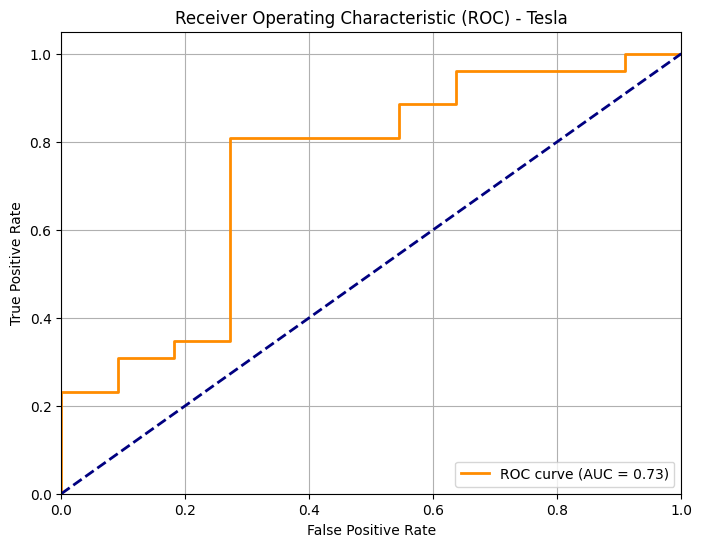

Generating SHAP Explanations...


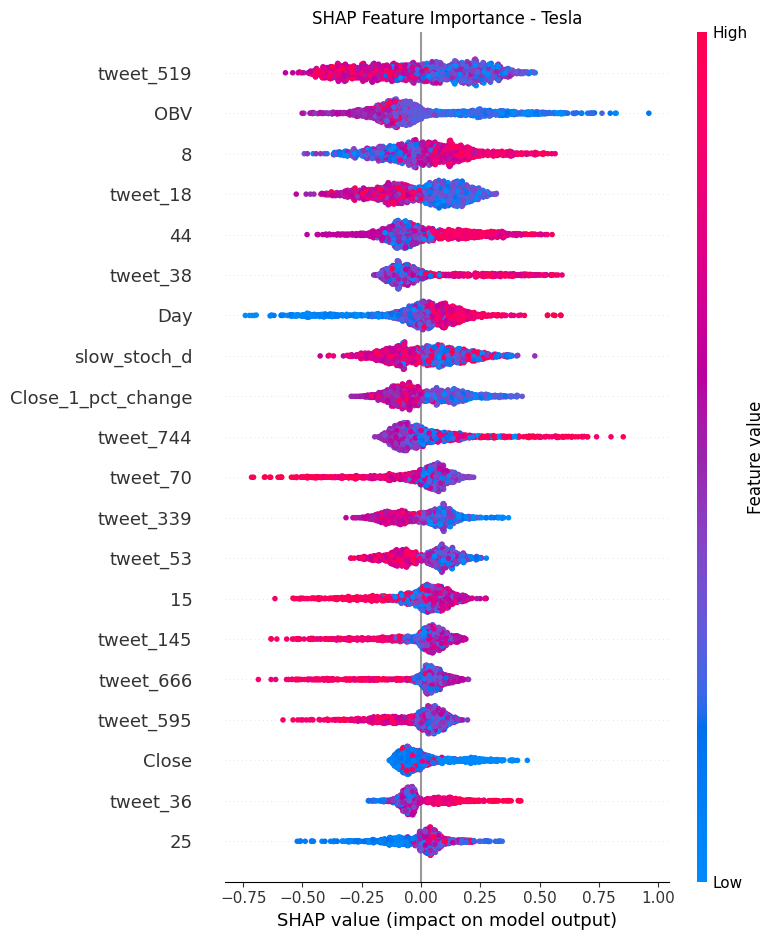

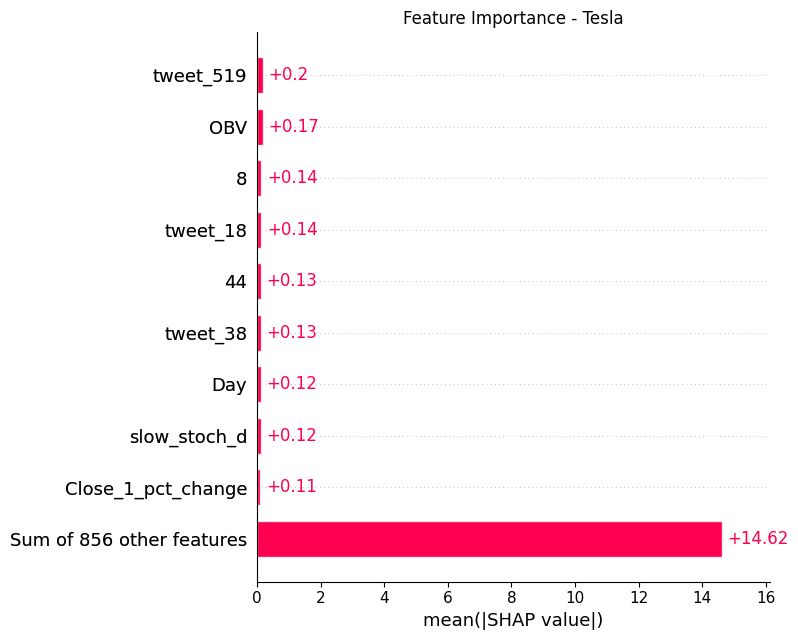


SHAP Force Plot for First Observation:


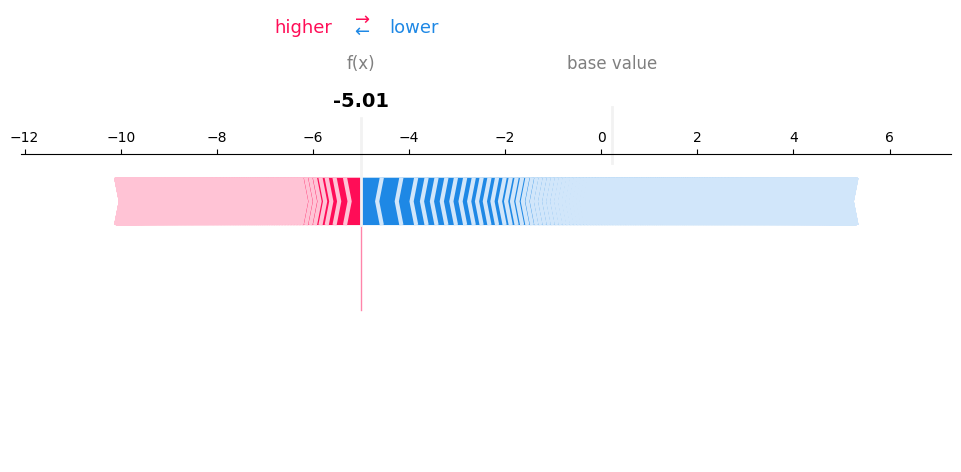

In [13]:
train_evaluate_and_explain_xgboost("Tesla", train_news_dr, y_train_tsla, test_news_dr, y_test_tsla, tsla_target_encoder)

SECOND BEST RESULT: TA + Tweets (Untransformed)

- Data Splitting

In [14]:
final_data_processed_body = final_data_processed_body.drop(['article', 'art_sentiment_class'], axis=1)
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = data_splitting(final_data_processed_body, "Target", 0.025)

- Model Evaluation

XGBoost Classifier Performance for Tesla:
----------------------------------------
Test Accuracy: 0.6757

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.73      0.85      0.79        26

    accuracy                           0.68        37
   macro avg       0.58      0.56      0.56        37
weighted avg       0.64      0.68      0.65        37


ROC AUC Score: 0.6713

Encoded Values and Class Names:
Encoded Value: 0, Class Name: Down
Encoded Value: 1, Class Name: Up



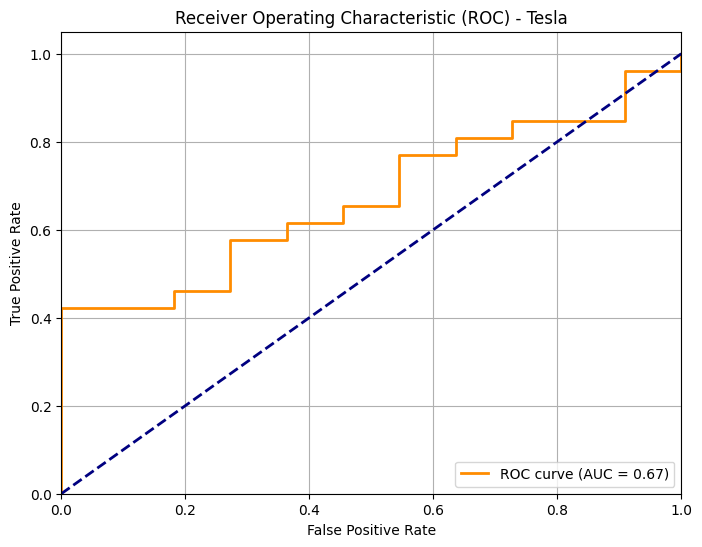

Generating SHAP Explanations...


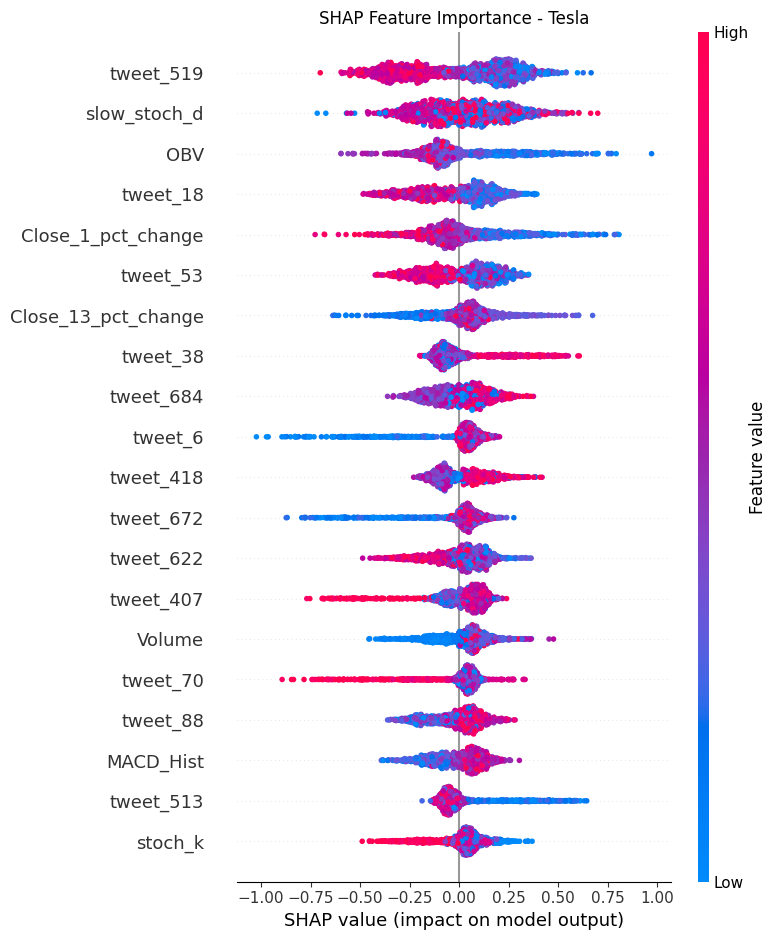

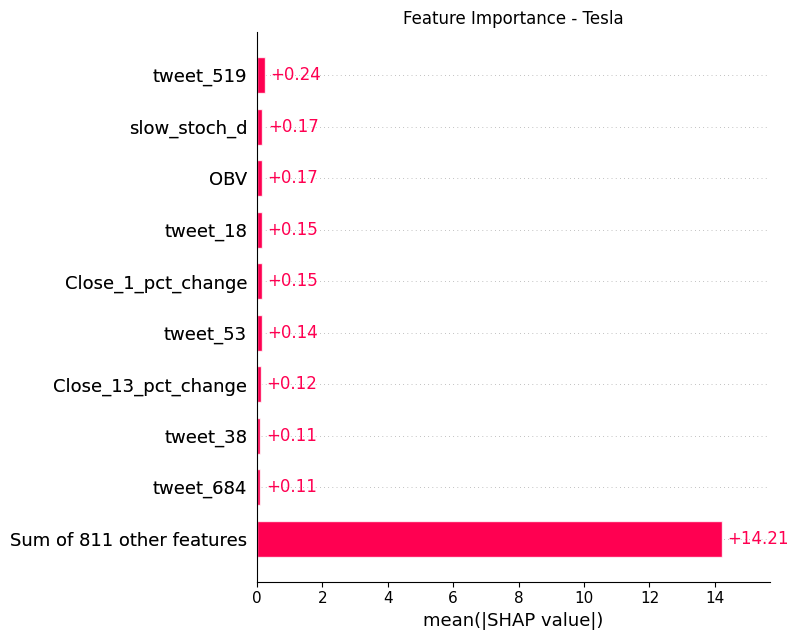


SHAP Force Plot for First Observation:


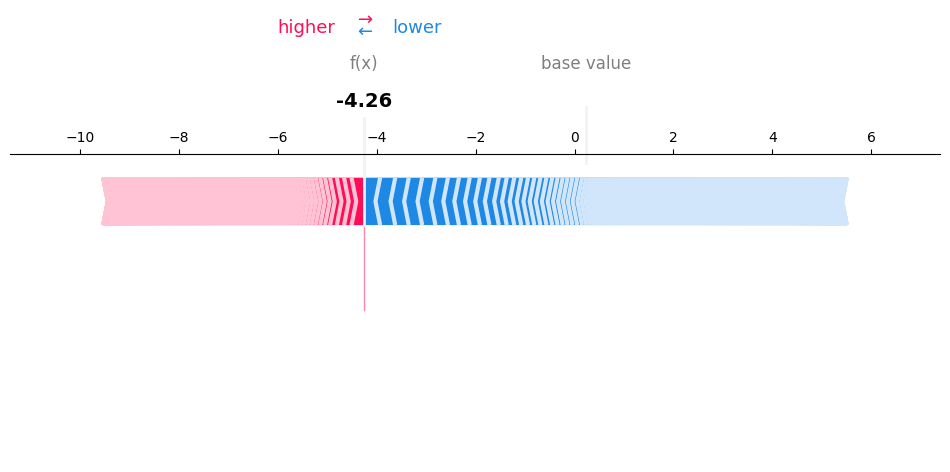

In [15]:
train_evaluate_and_explain_xgboost("Tesla", X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla, tsla_target_encoder)

THIRD BEST RESULT: TA Only

- Data Splitting

In [16]:
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = data_splitting(ta_only, "Target", 0.025)

- Model Evaluation

XGBoost Classifier Performance for Tesla:
----------------------------------------
Test Accuracy: 0.5405

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.64      0.45        11
           1       0.76      0.50      0.60        26

    accuracy                           0.54        37
   macro avg       0.56      0.57      0.53        37
weighted avg       0.64      0.54      0.56        37


ROC AUC Score: 0.5909

Encoded Values and Class Names:
Encoded Value: 0, Class Name: Down
Encoded Value: 1, Class Name: Up



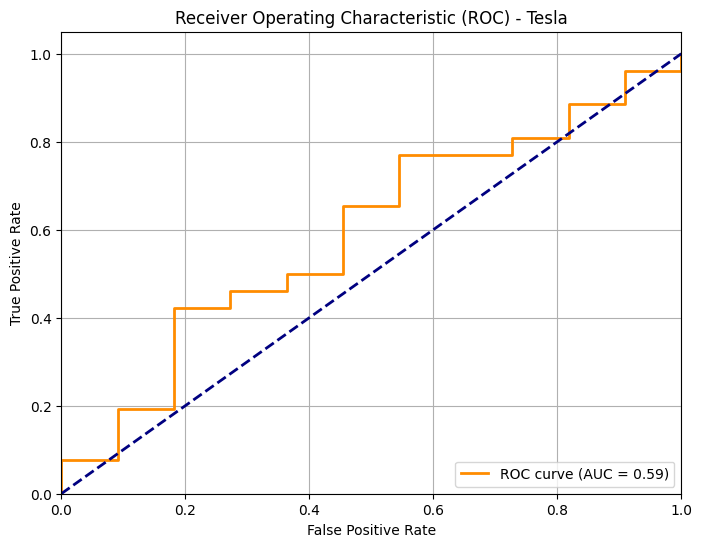

Generating SHAP Explanations...


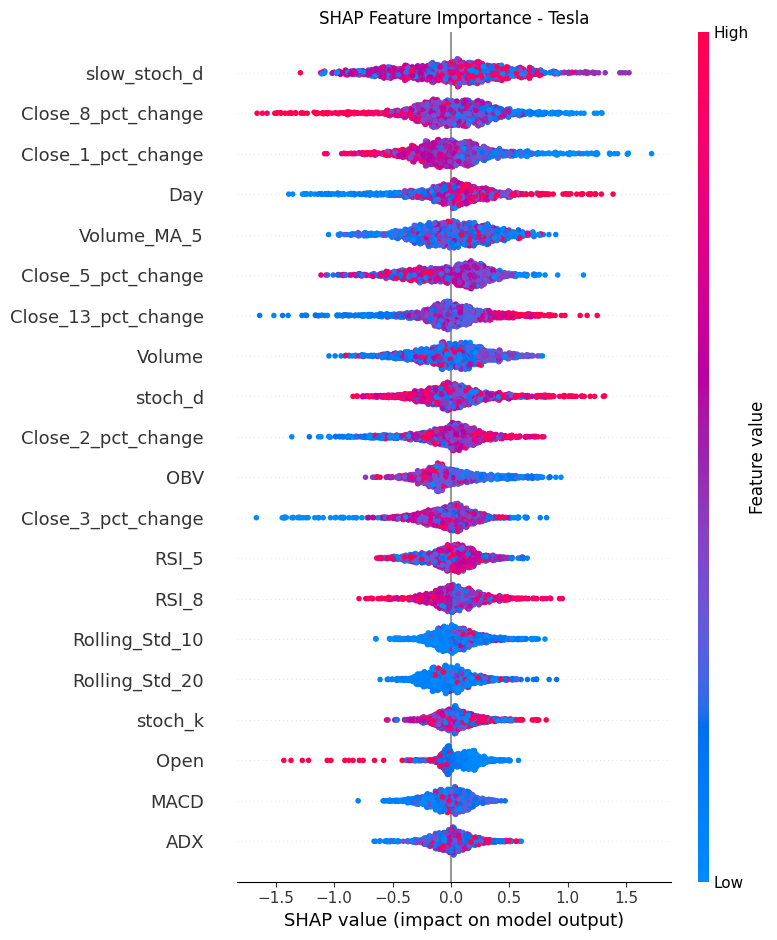

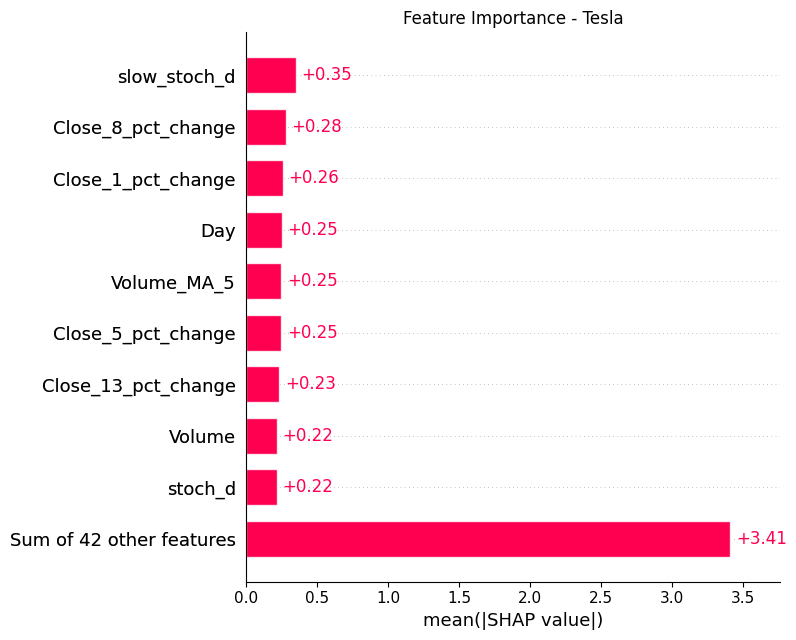


SHAP Force Plot for First Observation:


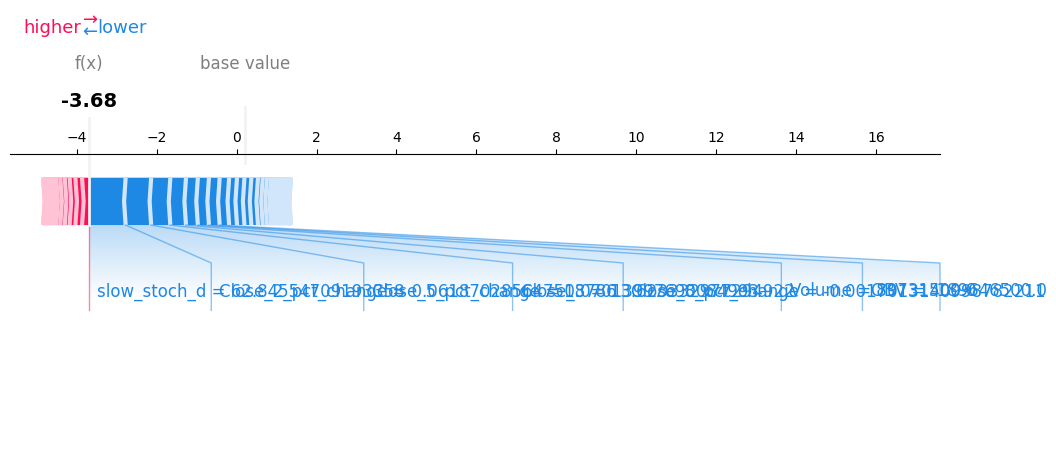

In [17]:
train_evaluate_and_explain_xgboost("Tesla", X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla, tsla_target_encoder)

Fourth Best Result: TA + tweets + News (Untransformed)

- Data Splitting

In [18]:
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = data_splitting(final_data_processed_all, "Target", 0.025)

- Model Evaluation

XGBoost Classifier Performance for Tesla:
----------------------------------------
Test Accuracy: 0.6757

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.36      0.40        11
           1       0.75      0.81      0.78        26

    accuracy                           0.68        37
   macro avg       0.60      0.59      0.59        37
weighted avg       0.66      0.68      0.67        37


ROC AUC Score: 0.5594

Encoded Values and Class Names:
Encoded Value: 0, Class Name: Down
Encoded Value: 1, Class Name: Up



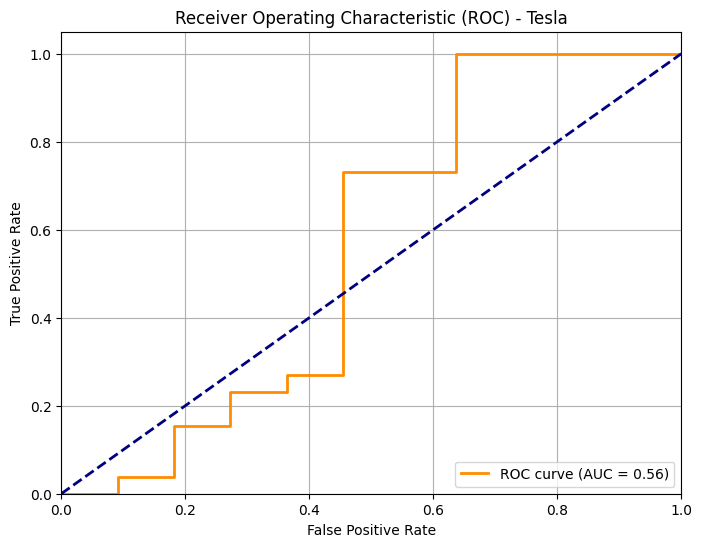

Generating SHAP Explanations...


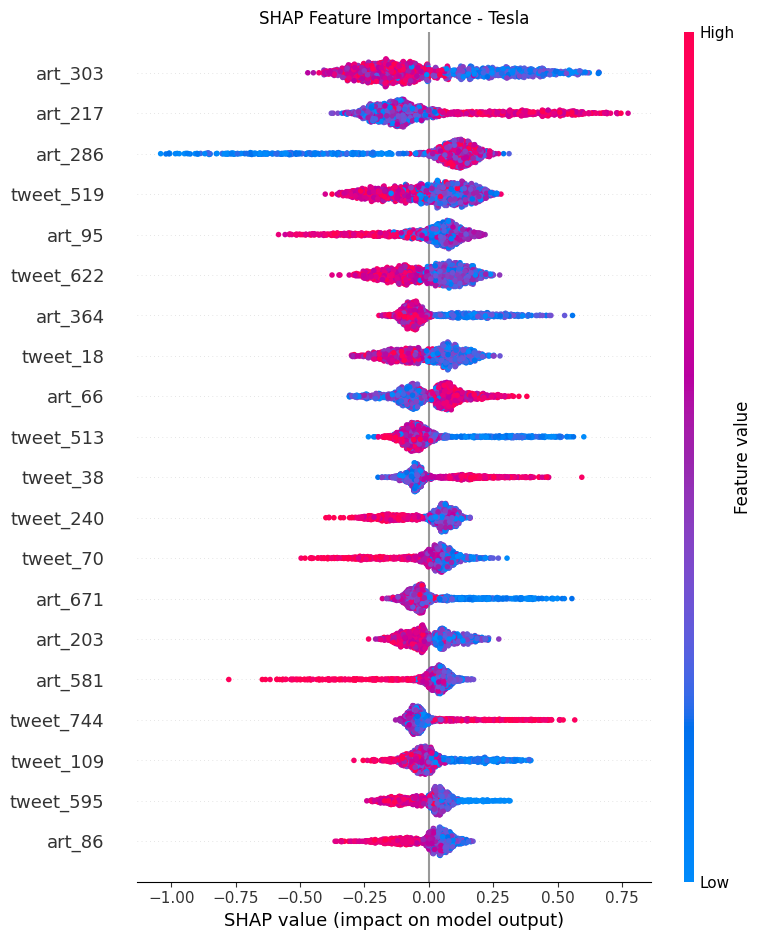

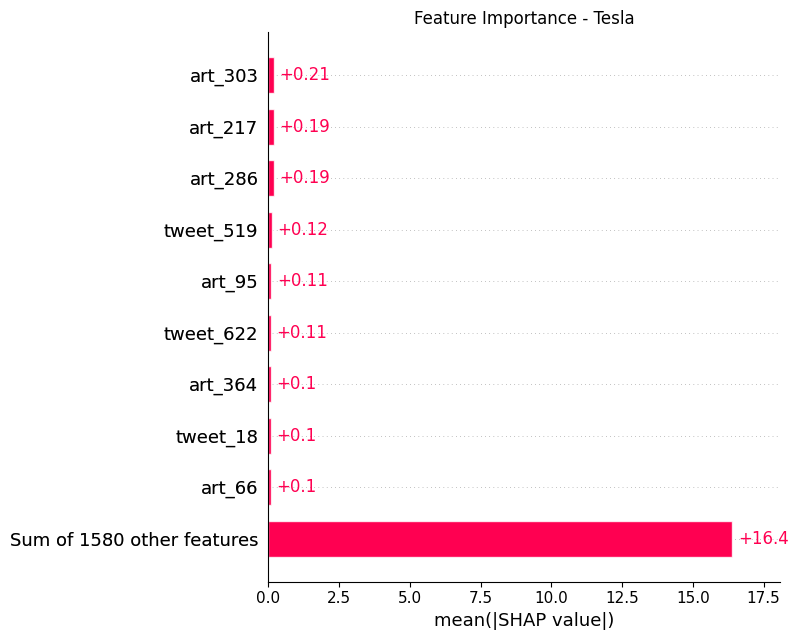


SHAP Force Plot for First Observation:


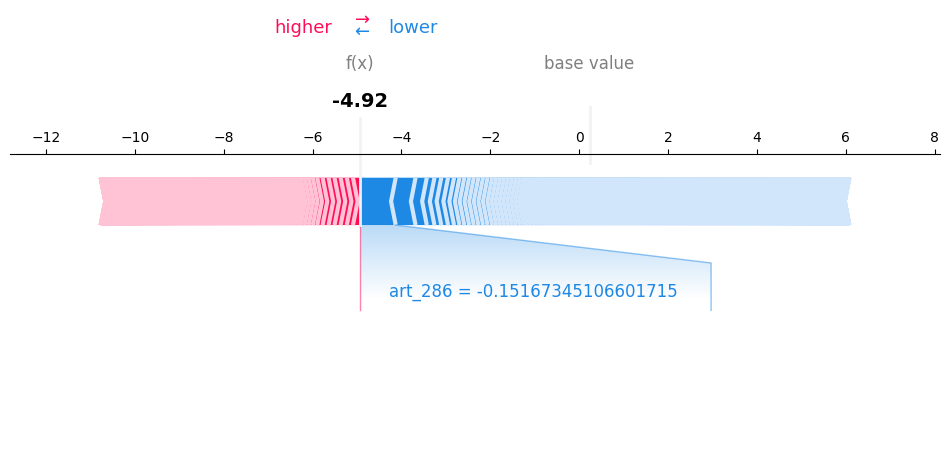

In [19]:
train_evaluate_and_explain_xgboost("Tesla", X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla, tsla_target_encoder)

Fifth Best Result: TA + News (UMAP)

- Data Splitting

In [20]:
X_train_ta, X_test_ta, y_train_tsla, y_test_tsla = data_splitting(ta_only, "Target", 0.025)
tr_ta_news_umap = X_train_ta.join(pd.DataFrame(tr_news_dr, index=x_tr_news.index))
te_ta_news_umap = X_test_ta.join(pd.DataFrame(te_news_dr, index=x_te_news.index))

- Model Evaluation

XGBoost Classifier Performance for Tesla:
----------------------------------------
Test Accuracy: 0.5946

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.18      0.21        11
           1       0.69      0.77      0.73        26

    accuracy                           0.59        37
   macro avg       0.47      0.48      0.47        37
weighted avg       0.56      0.59      0.57        37


ROC AUC Score: 0.5210

Encoded Values and Class Names:
Encoded Value: 0, Class Name: Down
Encoded Value: 1, Class Name: Up



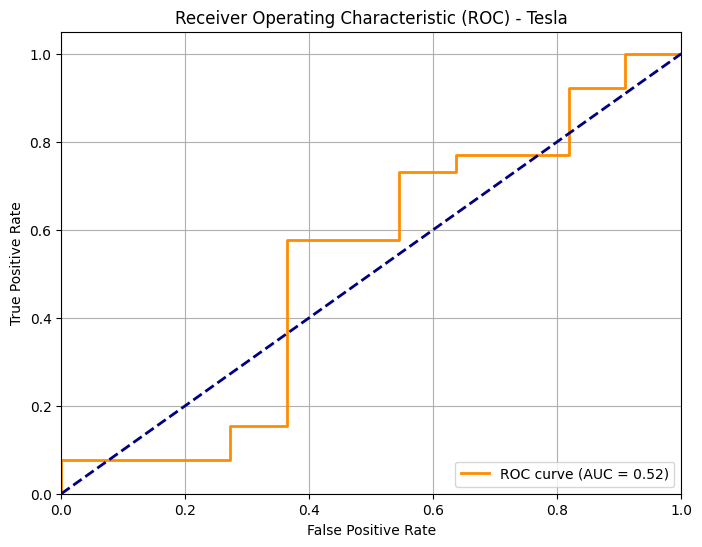

Generating SHAP Explanations...


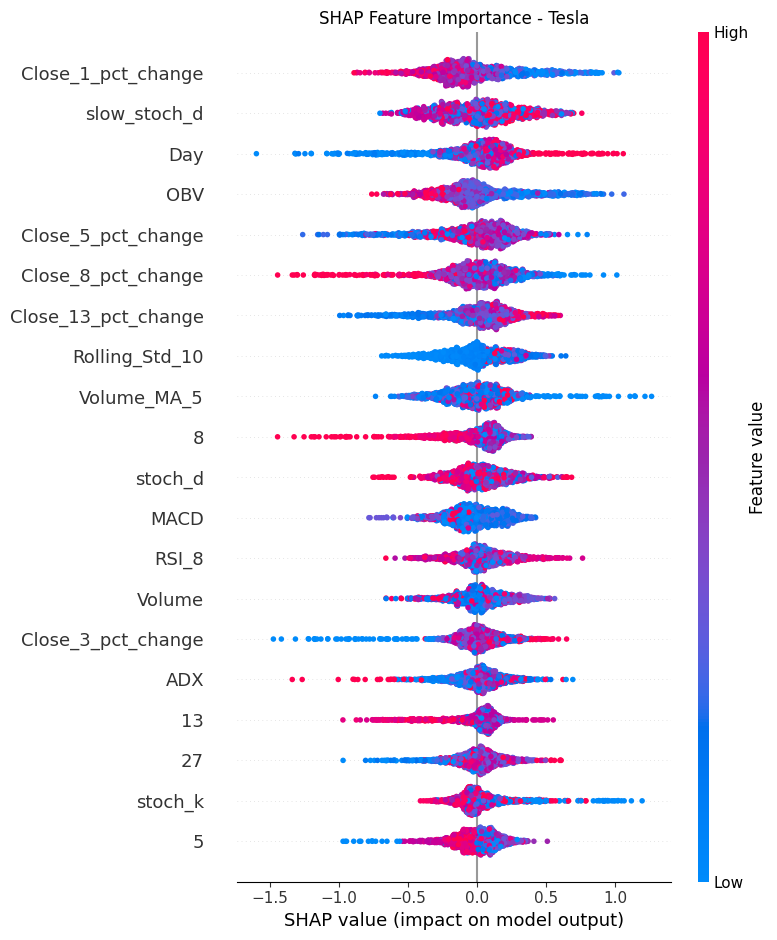

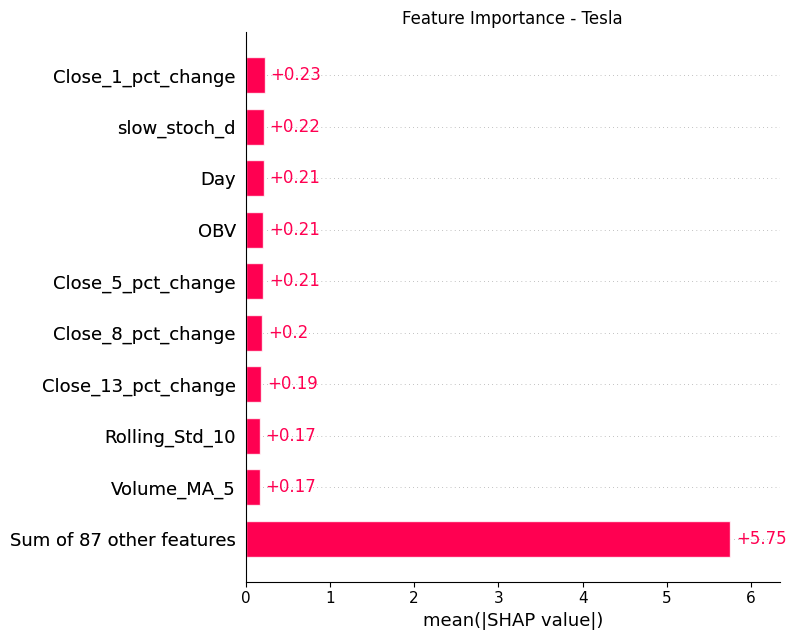


SHAP Force Plot for First Observation:


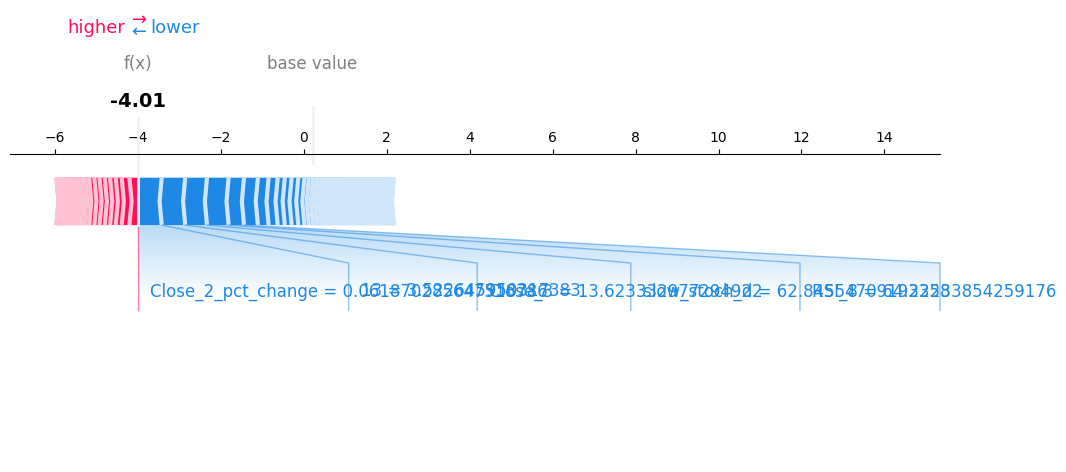

In [21]:
train_evaluate_and_explain_xgboost("Tesla", tr_ta_news_umap, y_train_tsla, te_ta_news_umap, y_test_tsla, tsla_target_encoder)

Worst Result: TA + News (Untransformed)

- Data Splitting

In [22]:
ta_news = ta_only.join(news_only.drop(['Target'], axis=1), how='inner')
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = data_splitting(ta_news, "Target", 0.025)

- Model Evaluation

XGBoost Classifier Performance for Tesla:
----------------------------------------
Test Accuracy: 0.4722

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.08      0.10        12
           1       0.59      0.67      0.63        24

    accuracy                           0.47        36
   macro avg       0.35      0.38      0.36        36
weighted avg       0.43      0.47      0.45        36


ROC AUC Score: 0.3368

Encoded Values and Class Names:
Encoded Value: 0, Class Name: Down
Encoded Value: 1, Class Name: Up



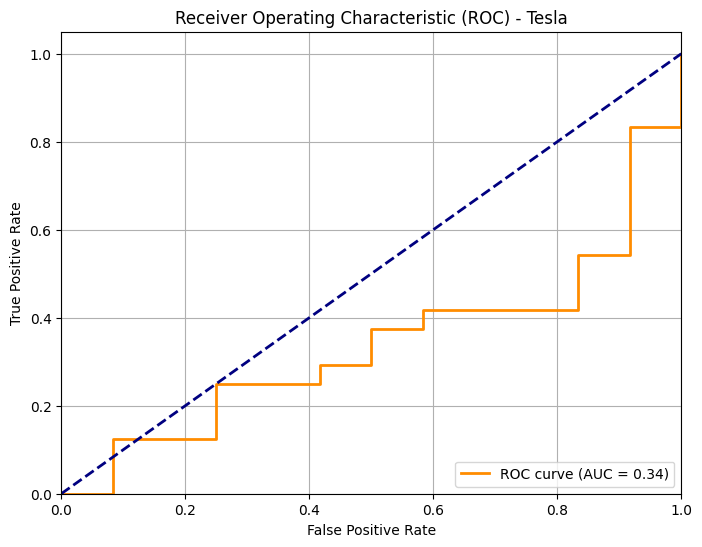

Generating SHAP Explanations...


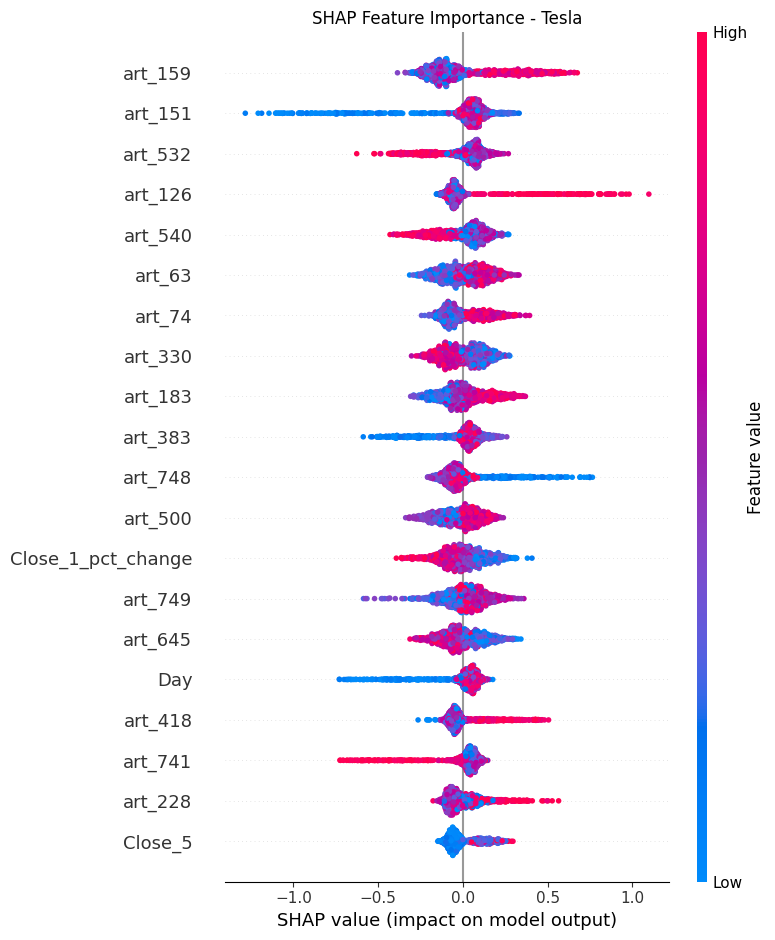

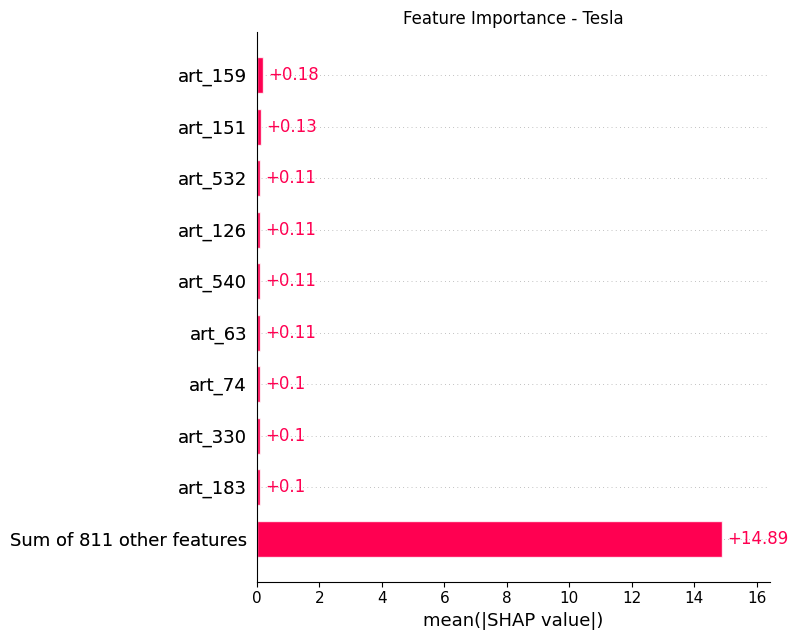


SHAP Force Plot for First Observation:


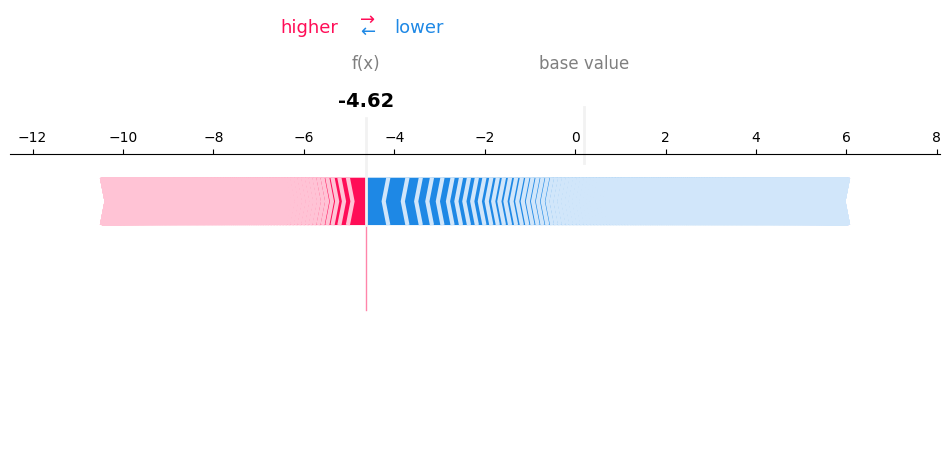

In [23]:
train_evaluate_and_explain_xgboost("Tesla", X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla, tsla_target_encoder)